# 2020 Primary Election Twitter Analysis

Scraped close to 482,000 Tweets about three candidates who were predicted to lead, along with tweets about the Iowa caucuses, for data exploration and analysis. Tweets were collected by Twint, running get_tweets.py daily, which saves the results in a pickle file.

# More EDA with TF-IDF vectorization
### Tokenizing, creating a bag of words, and determing the frequency of words and assigning weight to them

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_pickle('cleanDf.pkl')

In [3]:
df.shape

(455952, 15)

In [6]:
p1 = p1[0]

In [7]:
p2 = p2[0]

In [8]:
df = pd.concat([p1,p2,df],ignore_index=True)

/home/xristos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [9]:
df.shape

(484752, 39)

In [10]:
## after investigating the tweets some more, there were "pic.twitter" links
for i, row in tqdm(df.iterrows()):
    df.at[i,'tweet'] = re.sub("(pic.twitter.com)+\/.+",'',row['tweet'])
    
print(df.tweet[200])

484752it [03:04, 2632.16it/s]


By talking unions/livable wages for ALL. Puhlease.


In [5]:
# df.to_pickle('cleanDf.pkl')

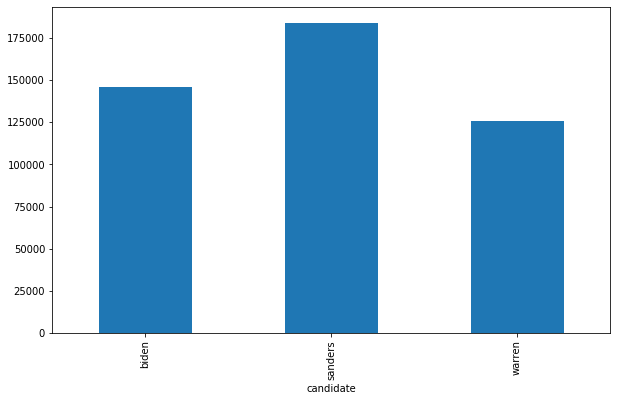

In [4]:
### distribution of tweets
df.groupby(['candidate'])['tweet'].count().plot(kind='bar',figsize=(10,6))
# plt.savefig('dist-tweets.png')

In [5]:
df.describe()

,likes,replies,retweets,ratio,sentiment
count,4.559520e+05,455952.000000,455952.000000,455952.000000,455952.000000
mean,7.708949e+02,54.302902,215.354382,0.117852,0.050909
std,5.940889e+03,466.304908,1720.854199,0.306633,0.485201
min,0.000000e+00,0.000000,0.000000,0.000000,-0.999500
25%,1.100000e+01,1.000000,1.000000,0.006791,-0.304900
50%,1.120000e+02,5.000000,19.000000,0.040741,0.000000
75%,3.260000e+02,21.000000,93.000000,0.105504,0.440400
max,1.911685e+06,93013.000000,460432.000000,34.195122,0.999500


In [6]:
print(df[df.retweets>93].shape)
print(df[df.retweets<93].shape)

(113318, 15)
(341814, 15)


In [7]:
df[df.retweets>93].head(10)

,id,date,timezone,tweet,user_id_str,likes,replies,retweets,search,near,geo,source,candidate,ratio,sentiment
12,1217957258467979265,2020-01-16 18:50:13,EST,Still talking about the Warren fib/lie/misunde...,20479813,534,107,114,joe biden,,,,biden,0.200375,-0.5610
53,1217948461443747840,2020-01-16 18:15:16,EST,Trump & Giuliani attempted to manufacture an i...,18382184,690,17,175,joe biden,,,,biden,0.024638,0.0000
63,1217947245955383296,2020-01-16 18:10:26,EST,"BREAKING: ""Coup Update: Senate must let Presid...",18247062,1028,36,454,joe biden,,,,biden,0.035019,-0.4926
64,1217947054850310145,2020-01-16 18:09:40,EST,"Dear USA, We dont like your President, can...",824472044913983488,215,6,120,joe biden,,,,biden,0.027907,0.2686
82,1217944574951329795,2020-01-16 17:59:49,EST,New: It looks like Ihor Kolomoisky used Lev Pa...,1489840663,257,9,153,joe biden,,,,biden,0.035019,0.3612
90,1217943813118926849,2020-01-16 17:56:48,EST,"""Is She (Pelosi) trying to payback President @...",56561449,2826,219,896,joe biden,,,,biden,0.077495,0.0000
95,1217943377674743808,2020-01-16 17:55:04,EST,Harris on Biden Testifying 👇 …,41634520,575,268,189,joe biden,,,,biden,0.466087,0.0000
104,1217942504110202883,2020-01-16 17:51:35,EST,Warren and Biden both backed it.Schumer Praise...,829715365223682048,381,12,107,joe biden,,,,biden,0.031496,-0.4404
106,1217942314934554624,2020-01-16 17:50:50,EST,"Today its Ukraine , GAO , Parmas , Giuliani , ...",1083551928821448710,270,9,143,joe biden,,,,biden,0.033333,-0.0772
115,1217941258351644673,2020-01-16 17:46:38,EST,"Obama, Biden, Comey, etc. discussed the Clinto...",50434327,113,5,148,joe biden,,,,biden,0.044248,0.2304


Below is a series of functions that are already part of the NLTK package. I made them before knowing that and leaving them here to understand the process of tokenizing, vectorizing, and calculating TF-IDF (scikit-learn will be used for that).

In [61]:
def tokenize_tweets(can_df):
    tokens = []
    for i,row in tqdm(can_df.iterrows()):
        tokens.append(row['tweet'].lower().split(' '))
    return [x for y in tokens for x in y]

## The tweets are not as clean as they could be -- punctuation should be removed
def clean_tweets(words):
    punct = ['.',',',"'","?","!",";",'(',')','"']
    for i in range(len(words)):
        for char in words[i]:
            if char in punct:
                words[i] = words[i].replace(char,'')
    return words

## vectorizing each tweet to have a count of each word -- creating bags of words
def vectorize(tokenized_tweet):
    unique_words = list(set(tokenized_tweet))
    bag_o_words = {word:0 for word in unique_words}
    for word in tokenized_tweet:
        bag_o_words[word]+=1
    return bag_o_words

## caculates the frequency of each word over the total number of unique words
def tf(bow):
    total_words = sum(bow.values())
    for word,value in bow.items():
        bow[word] = value / total_words
    return bow

### the inverse document frequency aims to lessen the weight of words that are very frequent--like the and is
def idf(docs):
    vocab = set()
    # loop list of docs and add words to vocab
    for doc in docs:
        for word in doc.keys():
            vocab.add(word)
    
    # create dict for full vocab word frequency
    full_vocab = {i:0 for i in vocab}
    
    for word, val in tqdm(full_vocab.items()):
        count = 0
        # loop through tweets to count words
        for doc in docs:
            if word in doc:
                count += 1
                
        # calculate IDF
        full_vocab[word] = np.log((len(docs)/ float(count)))
    
    return full_vocab

## calculate td-idf for each candidate's tweets
def tf_idf(docs):
    doc_tf_idf = {}
    idf_ = idf(docs)
    full_vocab_list = {i:0 for i in idf_.keys()}
    
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in tqdm(docs):
        doc_tf = tf(doc)
        for word in doc_tf:
            doc_tf_idf[word] = doc_tf[word] * idf_[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

# NLTK for analyzing tweets

In [3]:
from nltk.collocations import BigramCollocationFinder
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import BigramCollocationFinder
import string
import nltk

In [4]:
# tool for changing words to their root word
lemmatizer = WordNetLemmatizer()

In [5]:
# list of words and characters to filter
stop_words = stopwords.words('english')
stop_words += list(string.punctuation)
stop_words += ['but','back','A','Im','And','If','http','It','I',"The",'would','its','sen','ewarren','demdebate']

Tokenizing is the act of putting all of the words into a list. Once we have a list of all the words, I can filter through the list using our stop_words list.

In [6]:
## using regex to do an initial filtering of random characters
all_tokens = []
for tweet in tqdm(list(df['tweet'])):
    all_tokens.extend(nltk.regexp_tokenize(pattern="([a-zA-Z]+(?:'[a-z]+)?)",text=tweet.lower()))

100%|██████████| 455952/455952 [00:11<00:00, 40818.27it/s]


In [7]:
df.shape

(455952, 15)

In [12]:
df.groupby(['candidate']).describe()

likes                                                    \
              count        mean          std  min   25%    50%    75%   
candidate                                                               
biden      146117.0  793.420656  7834.767888  0.0  34.0  116.0  301.0   
sanders    184140.0  889.374471  5554.406908  0.0   8.0  164.0  417.0   
warren     125695.0  571.139703  3378.443069  0.0   9.0   74.0  215.0   

                       replies             ...     ratio            sentiment  \
                 max     count       mean  ...       75%        max     count   
candidate                                  ...                                  
biden      1911685.0  146117.0  66.213076  ...  0.120567  22.909091  146117.0   
sanders     905419.0  184140.0  52.143157  ...  0.090909  23.875000  184140.0   
warren      182548.0  125695.0  43.621624  ...  0.107143  34.195122  125695.0   

                                                                    
               mean       std     min     25%  50%     75%     max  
candidate                                                           
biden      0.015329  0.488072 -0.9995 -0.3612  0.0  0.4019  0.9995  
sanders    0.074586  0.484364 -0.9988 -0.2732  0.0  0.4671  0.9974  
warren     0.057584  0.480651 -0.9992 -0.2960  0.0  0.4404  0.9950  

[3 rows x 40 columns]

In [37]:
## this token function will be utilized when tokenizing tweets by candidate name
def tokenize(df, can):
    word_tokens = []
    for tweet in tqdm(list(df[df.candidate==can]['tweet'])):
        word_tokens.extend(nltk.regexp_tokenize(pattern="([a-zA-Z]+(?:'[a-z]+)?)",text=tweet.lower()))
    return word_tokens

def remove_stopwords(tokens,stop):
    return [token for token in tqdm(tokens) if not token in stop]

def lemmatizing(tokens):
    return [lemmatizer.lemmatize(token) for token in tqdm(tokens)]

''' Bigrams are a list of words and the word that follows. The function below takes in the tokens
    utilizes the NLTK BigramFinder, and calculates a normalized weight according to how frequent 
    the bigram appears in the tweets 
'''
def bigram_scores(tokens):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    return finder.score_ngrams(bigram_measures.raw_freq)

In [96]:
## creating a list of all the filtered words
all_filtered = [token for token in all_tokens if not token in stop_words]

## lemmatizing the filtered list
all_lemmatized = [lemmatizer.lemmatize(token) for token in all_filtered]

In [98]:
all_scores = bigram_scores(all_lemmatized)

## Top issues
To find out the top issues people are talking about, I created a list of words that are associated with popular issues. The function below iterates through all the bigrams and their weights. If one of the words of the bigram are in the list of issues, that word is added to the dictionary and the weight of the bigram is added to the value of the word. The end result is the sum of the weights for each issue.

In [78]:
def top_issues(scores,issues):
    top = {}
    for item in scores:
        top[item[0][0]] = 0
        top[item[0][1]] = 0
    for words in scores:
        if words[0][0] in issues:
            top[words[0][0]] += words[1] ## if the word in the bigram is an issue, add the bigram weight
        if words[0][1] in issues:
            top[words[0][1]] += words[1]
    return {k:v for k,v in top.items() if v > 0}

In [99]:
top_issues_all = top_issues(all_scores,issues)

In [100]:
top_issues_all

{'health': 0.0017087317071023834,
 'social': 0.0013667423892571454,
 'security': 0.001182080306441948,
 'debt': 0.0010162488965453594,
 'gun': 0.0009172360034569309,
 'school': 0.0011058464531744914,
 'military': 0.0007337888027655488,
 'china': 0.0007829915287788003,
 'inequality': 0.00023568713201409992,
 'defense': 0.0004154896863341342,
 'cannabis': 4.6469241234739506e-05,
 'immigrate': 2.4297642475680716e-06}

Now I'm going to tokenize, filter, lemmatize tweets grouped by candidate name.

In [41]:
bernie_tokens = tokenize(df,'sanders')
joey_tokens = tokenize(df,'biden')
lizzy_tokens = tokenize(df,'warren')

100%|██████████| 125695/125695 [00:03<00:00, 41173.92it/s]


In [43]:
bernie_filtered = remove_stopwords(bernie_tokens, stop_words)
joey_filtered = remove_stopwords(joey_tokens, stop_words)
lizzy_filtered = remove_stopwords(lizzy_tokens, stop_words)

100%|██████████| 3116043/3116043 [00:11<00:00, 281818.69it/s]


In [45]:
bernie_lemmatized = lemmatizing(bernie_filtered)
joey_lemmatized = lemmatizing(joey_filtered)
lizzy_lemmatized = lemmatizing(lizzy_filtered)

100%|██████████| 1802149/1802149 [00:15<00:00, 114704.99it/s]


In [49]:
bernie_scores = bigram_scores(bernie_lemmatized)
joey_scores = bigram_scores(joey_lemmatized)
lizzy_scores = bigram_scores(lizzy_lemmatized)

In [77]:
issues = ['health','social','security','inequality','debt','school','climate'
         'energy','gun','immigrate','cannabis','military','defense','taxes','china']

In [79]:
bernie_top = top_issues(bernie_scores,issues)
joey_top = top_issues(joey_scores, issues)
lizzy_top = top_issues(lizzy_scores, issues)

In [83]:
print(len(joey_top))
print(len(bernie_top))
print(len(lizzy_top))

12
12
11


In [86]:
joey_top

{'social': 0.001302479206404702,
 'security': 0.001515256055571304,
 'health': 0.0010843606790163476,
 'china': 0.0019221138801283684,
 'military': 0.0008021420129669117,
 'gun': 0.0008555587951844641,
 'school': 0.0008858283051077434,
 'debt': 0.00029557286160379284,
 'defense': 0.0005234844657320138,
 'inequality': 7.567377480820023e-05,
 'cannabis': 6.766125747556736e-05,
 'immigrate': 5.34167822175532e-06}

In [87]:
bernie_top

{'health': 0.0026699606168980173,
 'social': 0.0018491014904388444,
 'security': 0.0012987079551184466,
 'debt': 0.0012553388370058114,
 'school': 0.0009068088332642384,
 'inequality': 0.0004234402986634065,
 'gun': 0.0008397838325447116,
 'military': 0.0006702500071953116,
 'defense': 0.0002838705912827304,
 'china': 0.00019949794331814092,
 'cannabis': 3.942647101149012e-05,
 'immigrate': 1.5770588404596023e-06}

In [88]:
lizzy_top

{'health': 0.001134201445052519,
 'debt': 0.0015781159049556624,
 'school': 0.0016602400800377328,
 'social': 0.0007679720156324517,
 'security': 0.0006026138793185284,
 'military': 0.000738007789588989,
 'gun': 0.0011031274328593057,
 'inequality': 0.0001709070670627125,
 'defense': 0.00046611018289829953,
 'china': 0.000184224500859807,
 'cannabis': 2.9964226043462576e-05}